Sentiment Analysis on Tweets || Lochan Basyal

In [ ]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is alr

In [ ]:
# keys and tokens from the Twitter Dev Console
consumer_key = 'XXXXXXXXXXXXXXXXXXXXX'
consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXX'
access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXX'
access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXX'


In [ ]:
class TwitterClient(object): 
    def __init__(self): 
        #Initialization method. 
        try: 
            # create OAuthHandler object 
            auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            # add hyper parameter 'proxy' if executing from behind proxy "proxy='http://172.22.218.218:8085'"
            self.api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            
        except tweepy.TweepError as e:
            print(f"Error: Tweeter Authentication Failed - \n{str(e)}")

    def get_tweets(self, query, maxTweets = 1000):
        #Function to fetch tweets. 
        # empty list to store parsed tweets 
        tweets = [] 
        sinceId = None
        max_id = -1
        tweetCount = 0
        tweetsPerQry = 100

        while tweetCount < maxTweets:
            try:
                if (max_id <= 0):
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry)
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                since_id=sinceId)
                else:
                    if (not sinceId):
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1))
                    else:
                        new_tweets = self.api.search(q=query, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId)
                if not new_tweets:
                    print("No more tweets found")
                    break

                for tweet in new_tweets:
                    parsed_tweet = {} 
                    parsed_tweet['tweets'] = tweet.text 

                    # appending parsed tweet to tweets list 
                    if tweet.retweet_count > 0: 
                        # if tweet has retweets, ensure that it is appended only once 
                        if parsed_tweet not in tweets: 
                            tweets.append(parsed_tweet) 
                    else: 
                        tweets.append(parsed_tweet) 
                        
                tweetCount += len(new_tweets)
                print("Downloaded {0} tweets".format(tweetCount))
                max_id = new_tweets[-1].id

            except tweepy.TweepError as e:
                # Just exit if any error
                print("Tweepy error : " + str(e))
                break
        
        return pd.DataFrame(tweets)

In [ ]:
twitter_client = TwitterClient()

# calling function to get tweets
tweets_df = twitter_client.get_tweets('AI and Deep learning', maxTweets=7000)
print(f'tweets_df Shape - {tweets_df.shape}')
tweets_df.head(10)

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 799 tweets
Downloaded 898 tweets
Downloaded 998 tweets
Downloaded 1096 tweets
Downloaded 1196 tweets
Downloaded 1296 tweets
Downloaded 1396 tweets
Downloaded 1496 tweets
Downloaded 1591 tweets
Downloaded 1678 tweets
Downloaded 1778 tweets
Downloaded 1878 tweets
Downloaded 1978 tweets
Downloaded 2003 tweets
No more tweets found
tweets_df Shape - (961, 1)


,tweets
0,RT @sapinker: Some of the deep problems with A...
1,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...
3,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...
5,Some of the deep problems with AI deep learnin...
6,Rule-based machine vision is limited to quanti...
7,https://t.co/poMzHH3BGa\nAre you getting the h...
8,I updated ChatGPT dataset. Now it knows me😀 We...
9,Learn about the benefits enterprises are enjoy...


Fetch Sentiments

In [ ]:
# 1 way
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

# 2 way
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

Using NLTK's SentimentIntensityAnalyzer

In [ ]:
sentiments_using_SIA = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,tweets
pos,883
neg,78


Using TextBlob

In [ ]:
sentiments_using_textblob = tweets_df.tweets.apply(lambda tweet: fetch_sentiment_using_textblob(tweet))
pd.DataFrame(sentiments_using_textblob.value_counts())

,tweets
pos,851
neg,110


In [ ]:
tweets_df['sentiment'] = sentiments_using_textblob
tweets_df.head()

,tweets,sentiment
0,RT @sapinker: Some of the deep problems with A...,pos
1,"Amelia's got an incredible life story, a deep ...",pos
2,RT @columbiacss: Explore current issues in AI ...,pos
3,Wondering what’s the latest in #AI? Discover h...,pos
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos


Text Pre-Processing

Pre-Processing 'Key Words'

Removing '@names'

In [ ]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text 

In [ ]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
tweets_df['tidy_tweets'] = np.vectorize(remove_pattern)(tweets_df['tweets'], "@[\w]*: | *RT*")
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learni...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a ...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine ..."
5,Some of the deep problems with AI deep learnin...,pos,Some of the deep problems with AI deep learnin...
6,Rule-based machine vision is limited to quanti...,pos,ule-based machine vision is limited to quantif...
7,https://t.co/poMzHH3BGa\nAre you getting the h...,neg,https://t.co/poMzHH3BGa\nAre you getting the h...
8,I updated ChatGPT dataset. Now it knows me😀 We...,pos,I updated ChatGPT dataset. Now it knows me😀 We...
9,Learn about the benefits enterprises are enjoy...,pos,Learn about the benefits enterprises are enjoy...


Removing links (http | https)

In [ ]:
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.tidy_tweets.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

tweets_df['tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a..."
5,Some of the deep problems with AI deep learnin...,pos,Some of the deep problems with AI deep learnin...
6,Rule-based machine vision is limited to quanti...,pos,ule-based machine vision is limited to quantif...
7,https://t.co/poMzHH3BGa\nAre you getting the h...,neg,Are you getting the heat and inspiration in AI...
8,I updated ChatGPT dataset. Now it knows me😀 We...,pos,I updated ChatGPT dataset. Now it knows me😀 We...
9,Learn about the benefits enterprises are enjoy...,pos,Learn about the benefits enterprises are enjoy...


Removing tweets with empty text

In [ ]:
tweets_df = tweets_df[tweets_df['tidy_tweets']!='']
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a..."


Dropping duplicate rows

In [ ]:
tweets_df.drop_duplicates(subset=['tidy_tweets'], keep=False)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a..."


Resetting index

In [ ]:
tweets_df = tweets_df.reset_index(drop=True)
tweets_df.head()

,tweets,sentiment,tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a..."


Removing Punctuations, Numbers and Special characters

In [ ]:
tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")

<ipython-input-61-d16302e73904>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['absolute_tidy_tweets'] = tweets_df['tidy_tweets'].str.replace("[^a-zA-Z# ]", "")


Removing Stop words

In [ ]:
stopwords_set = set(stopwords)
cleaned_tweets = []

for index, row in tweets_df.iterrows():
    
    # filtering out all the stopwords 
    words_without_stopwords = [word for word in row.absolute_tidy_tweets.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
tweets_df['absolute_tidy_tweets'] = cleaned_tweets
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...,Some deep problems AI deep learning including ...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ...",Amelias got incredible life story deep passion...
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...,Explore current issues AI research philosophic...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...,Wondering whats latest Discover highlights bui...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a...",Good news emsejournal paper A Machine Deep Lea...
5,Some of the deep problems with AI deep learnin...,pos,Some of the deep problems with AI deep learnin...,Some deep problems AI deep learning including ...
6,Rule-based machine vision is limited to quanti...,pos,ule-based machine vision is limited to quantif...,ulebased machine vision limited quantifiable c...
7,https://t.co/poMzHH3BGa\nAre you getting the h...,neg,Are you getting the heat and inspiration in AI...,Are getting heat inspiration AI Yes Artificial...
8,I updated ChatGPT dataset. Now it knows me😀 We...,pos,I updated ChatGPT dataset. Now it knows me😀 We...,I updated ChatGPT dataset Now knows We deal Ma...
9,Learn about the benefits enterprises are enjoy...,pos,Learn about the benefits enterprises are enjoy...,Learn benefits enterprises enjoying innovations


Tokenize *'absolute_tidy_tweets'*

In [ ]:
tokenized_tweet = tweets_df['absolute_tidy_tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [Some, deep, problems, AI, deep, learning, inc...
1    [Amelias, got, incredible, life, story, deep, ...
2    [Explore, current, issues, AI, research, philo...
3    [Wondering, whats, latest, Discover, highlight...
4    [Good, news, emsejournal, paper, A, Machine, D...
Name: absolute_tidy_tweets, dtype: object

Converting words to Lemma

In [ ]:
import nltk
nltk.download('omw-1.4')

word_lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    [Some, deep, problem, AI, deep, learning, incl...
1    [Amelias, got, incredible, life, story, deep, ...
2    [Explore, current, issue, AI, research, philos...
3    [Wondering, whats, latest, Discover, highlight...
4    [Good, news, emsejournal, paper, A, Machine, D...
Name: absolute_tidy_tweets, dtype: object

Joining all tokens into sentences

In [ ]:
for i, tokens in enumerate(tokenized_tweet):
    tokenized_tweet[i] = ' '.join(tokens)

tweets_df['absolute_tidy_tweets'] = tokenized_tweet
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...,Some deep problem AI deep learning including C...
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ...",Amelias got incredible life story deep passion...
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...,Explore current issue AI research philosophica...
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...,Wondering whats latest Discover highlight buil...
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a...",Good news emsejournal paper A Machine Deep Lea...
5,Some of the deep problems with AI deep learnin...,pos,Some of the deep problems with AI deep learnin...,Some deep problem AI deep learning including C...
6,Rule-based machine vision is limited to quanti...,pos,ule-based machine vision is limited to quantif...,ulebased machine vision limited quantifiable c...
7,https://t.co/poMzHH3BGa\nAre you getting the h...,neg,Are you getting the heat and inspiration in AI...,Are getting heat inspiration AI Yes Artificial...
8,I updated ChatGPT dataset. Now it knows me😀 We...,pos,I updated ChatGPT dataset. Now it knows me😀 We...,I updated ChatGPT dataset Now know We deal Mac...
9,Learn about the benefits enterprises are enjoy...,pos,Learn about the benefits enterprises are enjoy...,Learn benefit enterprise enjoying innovation


Pre-processing 'Key Phrases'

Helper class, will help in preprocessing phrase terms

In [ ]:
class PhraseExtractHelper(object):
    def __init__(self):
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stemmer = nltk.stem.porter.PorterStemmer()
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        # word = self.stemmer.stem_word(word) # We will loose the exact meaning of the word 
        word = self.lemmatizer.lemmatize(word)
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword. We can increase the length if we want to consider large phrase"""
        accepted = bool(3 <= len(word) <= 40
            and word.lower() not in stopwords
            and 'https' not in word.lower()
            and 'http' not in word.lower()
            and '#' not in word.lower()
            )
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,t in leaf if self.acceptable_word(w) ]
            yield term

Grammatical rule to identify phrases

In [ ]:
sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

New feature called 'key_phrases', will contain phrases for corresponding tweet

In [ ]:
key_phrases = []
phrase_extract_helper = PhraseExtractHelper()

for index, row in tweets_df.iterrows(): 
    toks = nltk.regexp_tokenize(row.tidy_tweets, sentence_re)
    postoks = nltk.tag.pos_tag(toks)
    tree = chunker.parse(postoks)

    terms = phrase_extract_helper.get_terms(tree)
    tweet_phrases = []

    for term in terms:
        if len(term):
            tweet_phrases.append(' '.join(term))
    
    key_phrases.append(tweet_phrases)
    
key_phrases[:10]

[['deep problem',
  'deep learning',
  'chatgpt',
  'year',
  'garymarcus',
  ' me, jerry'],
 ['amelia',
  'incredible life story',
  'deep passion',
  'education',
  'great insight'],
 ['current issue',
  'research',
  'philosophical perspective',
  'columbia university',
  ' nyu',
  'march'],
 ['discover highlight', ' ai, machine learning'],
 ['good news',
  'emsejournal paper "a m achine',
  'deep learning analysis',
  'sonarqube rule',
  'product',
  'process'],
 ['deep problem', 'deep learning', 'chatgpt', 'year', 'garymarcus'],
 ['ule-based machine vision',
  'specific characteristic',
  'deep learning',
  'subset'],
 ['heat',
  'inspiration',
  ' ai? yes',
  'artificial intelligence',
  'deep learning'],
 ['chatgpt dataset', 'machine learning', 'deep learning', 'project', 'pyt'],
 ['benefit enterprise', 'innovation', 'achinelearning', 'deeplearning']]

In [ ]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in tweets_df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.tidy_tweets.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['jerry f…'],
 ['amelia', 'incredible life story', 'deep passion', 'ai education'],
 ['ai research',
  'philosophical perspective',
  'columbia university',
  'nyu',
  'march 24-26.…'],
 ['discover', 'machine learning'],
 ['good news',
  'emsejournal paper',
  'machine',
  'deep learning analysis',
  'product',
  'process me…'],
 [],
 ['machine vision', 'deep learning'],
 ['artificial intelligence', 'deep learning…'],
 ['updated chatgpt dataset', 'machine learning', 'deep learning', 'pyt…'],
 []]

In [ ]:
tweets_df['key_phrases'] = textblob_key_phrases
tweets_df.head(10)

,tweets,sentiment,tidy_tweets,absolute_tidy_tweets,key_phrases
0,RT @sapinker: Some of the deep problems with A...,pos,Some of the deep problems with AI deep learnin...,Some deep problem AI deep learning including C...,[jerry f…]
1,"Amelia's got an incredible life story, a deep ...",pos,"Amelia's got an incredible life story, a deep ...",Amelias got incredible life story deep passion...,"[amelia, incredible life story, deep passion, ..."
2,RT @columbiacss: Explore current issues in AI ...,pos,Explore current issues in AI research from a p...,Explore current issue AI research philosophica...,"[ai research, philosophical perspective, colum..."
3,Wondering what’s the latest in #AI? Discover h...,pos,Wondering what’s the latest in #AI? Discover h...,Wondering whats latest Discover highlight buil...,"[discover, machine learning]"
4,RT @vale_lenarduzzi: Good news: our @emsejourn...,pos,"Good news: our @emsejournal paper ""A Machine a...",Good news emsejournal paper A Machine Deep Lea...,"[good news, emsejournal paper, machine, deep l..."
5,Some of the deep problems with AI deep learnin...,pos,Some of the deep problems with AI deep learnin...,Some deep problem AI deep learning including C...,[]
6,Rule-based machine vision is limited to quanti...,pos,ule-based machine vision is limited to quantif...,ulebased machine vision limited quantifiable c...,"[machine vision, deep learning]"
7,https://t.co/poMzHH3BGa\nAre you getting the h...,neg,Are you getting the heat and inspiration in AI...,Are getting heat inspiration AI Yes Artificial...,"[artificial intelligence, deep learning…]"
8,I updated ChatGPT dataset. Now it knows me😀 We...,pos,I updated ChatGPT dataset. Now it knows me😀 We...,I updated ChatGPT dataset Now know We deal Mac...,"[updated chatgpt dataset, machine learning, de..."
9,Learn about the benefits enterprises are enjoy...,pos,Learn about the benefits enterprises are enjoy...,Learn benefit enterprise enjoying innovation,[]


Story Generation and Visualization

Most common words in positive tweets

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

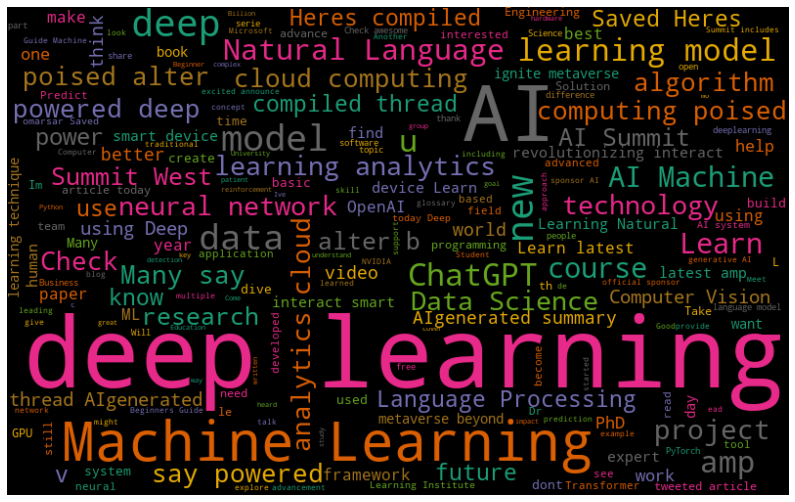

In [ ]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'pos']])
generate_wordcloud(all_words)

Most common words in negative tweets

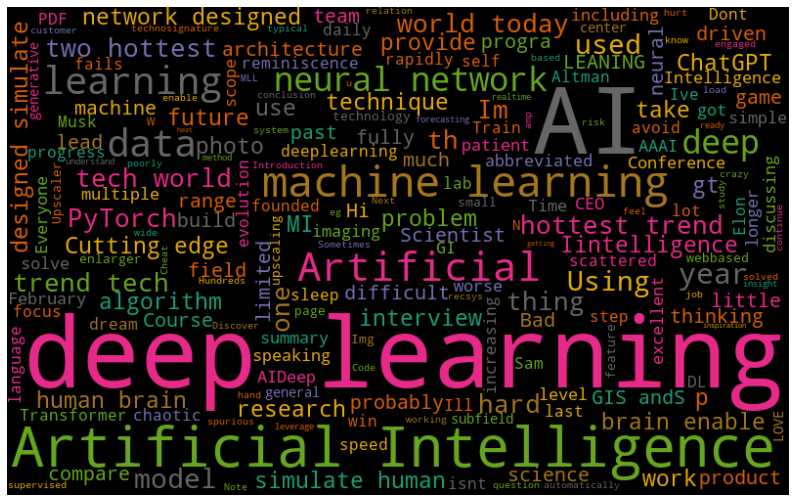

In [ ]:
all_words = ' '.join([text for text in tweets_df['absolute_tidy_tweets'][tweets_df.sentiment == 'neg']])
generate_wordcloud(all_words)

Most commonly used Hashtags

In [ ]:
# function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 25 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()


In [ ]:
hashtags = hashtag_extract(tweets_df['tidy_tweets'])
hashtags = sum(hashtags, [])

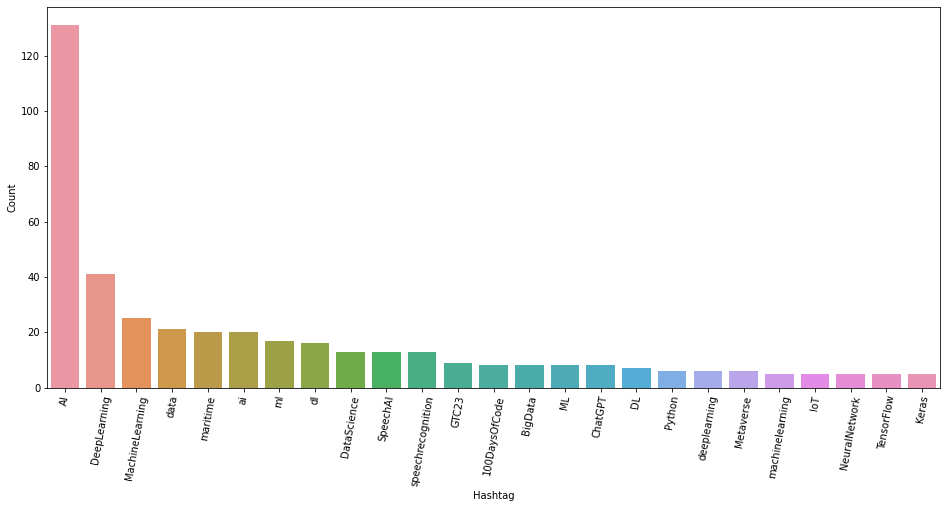

In [ ]:
generate_hashtag_freqdist(hashtags)

In [ ]:
# For sake of consistency, we are going to discard the records which contains no phrases i.e where tweets_df['key_phrases'] contains []
tweets_df2 = tweets_df[tweets_df['key_phrases'].str.len()>0]

Feature Extraction

Bag of words (Simple vectorization) || 
TF-IDF (Term Frequency - Inverse Document Frequency)

Feature Extraction for 'Key Words'

In [ ]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(tweets_df2['absolute_tidy_tweets'])

Feature Extraction for 'Key Phrases'

In [ ]:
phrase_sents = tweets_df2['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

Model Building: Sentiment Analysis

Map target variables to {0, 1}

In [ ]:
target_variable = tweets_df2['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

In [ ]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [ ]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

Predictions on 'key words' based features

BOW word features

Accuracy Score - 0.8821138211382114


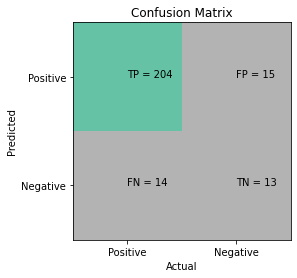

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

TF-IDF word features

Accuracy Score - 0.8780487804878049


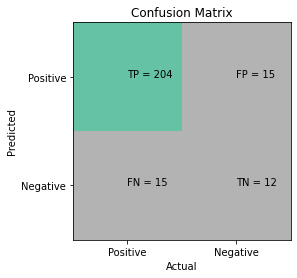

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Predictions on 'key phrases' based features

BOW Phrase features

Accuracy Score - 0.7682926829268293


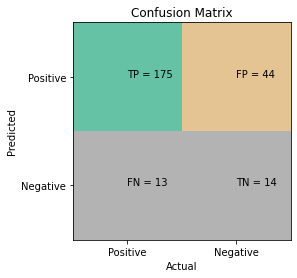

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

TF-IDF Phrase features

Accuracy Score - 0.7642276422764228


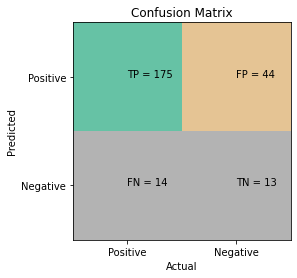

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Features extracted from 'key words' helps model in performing better. They have better positive predictions than the later one. However, using 'key-phrase' based features improves the negative predictions.